# Inverse kinematics
This notebook considers the problem of inverse kinematics, ie solving at each control cycle of the robot a quadratic program from the derivatives (jacobian) of the current state. It introduces the basic function to compute the Jacobians of the robot, and how to use them to compute an inverse-kinematics control law. One of the key difficulties is to understand in which frames each quantities is computed (might be in the world frame, in the local frame attached to the end effector, in some arbitrary goal frame, etc), as we should never mixed quantities expressed in different frames without transporting them in the right frame. 


## Set up
We will use a Gepetto-viewer, and the linear algebra of NumPy.

In [1]:
import pinocchio as pin
import numpy as np
import time
from numpy.linalg import pinv,inv,norm,svd,eig
from utils.tiago_loader import loadTiago
import matplotlib.pylab as plt; plt.ion()
from utils.meshcat_viewer_wrapper import MeshcatVisualizer

We will use the Tiago robot (https://youtu.be/6BwRqwD066g). This mobile manipulator from PAL Robotics:
- has a mobile basis which can move in the plane (3 dof)
- a manipulator arm (7 dof)
- a head (2 dof) both mounted on a prismatic axis moving vertically (1 dof).

This makes 
- 3 dof for the basis
- 9 dof for the body.

It also has 2 extra joints tot figure the wheels, which are not very useful for this notebook. 

The wheels and the basis rotations are represented by the cos and sin of the angle.
The size of the configuration vector is then 18, while the velocity vector has dimension 15.

A load function is available to make it easy to load the robot.

In [2]:
robot = loadTiago()
viz = MeshcatVisualizer(robot)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
# viz.viewer.jupyter_cell()

The configuration is represented by a vector of larger dimension, subject to constraints ( e.g. $cos^2+sin^2=1$).

It is not possible to randomly sample a configuration vector q, as these constraints should be respected.

Similarly, we should take care when integrating a velocity as summing a configuration q with a velocity v will not work (dimensions do not match).

Two functions in Pinocchio implements these functionnalities.

In [ ]:
print(f"Velocity vector has {robot.model.nv} components")

In [ ]:
np.random.seed(47)
q = pin.randomConfiguration(robot.model)
vq = np.random.rand(robot.model.nv)*2 - 1
DT = 1e-3
qnext = pin.integrate(robot.model, q, vq*DT)

A simple example moving the robot in the viewer following a constant (random) velocity is as follows.

In [ ]:
for t in range(1000):
    q = pin.integrate(robot.model,q,vq*DT)
    viz.display(q)
    time.sleep(DT/10)

The robot is mobile, hence the camera view in the viewer is not always centered. 

## Forward kinematics and Jacobian

- We recall first the basic method to compute the robot forward kinematics.

We will consider two frames of interest on the robot: 
- the first one, named <tool> is at the tip of the end-effector
- the second one, named <basis>, is on the front of the robot basis, 10 cm above the ground.

Both are represented in Gepetto-Viewer by a frame composed of three RGB arrows. 

![](figures/frames_of_interest.png)

In [ ]:
IDX_TOOL = robot.model.getFrameId('frametool')
IDX_BASIS = robot.model.getFrameId('framebasis')

In [ ]:
# for i in range(79):
#     print( robot.model.frames[i])
robot.model.frames[IDX_TOOL]
# I=quadratic moment of the mesh, m = mass

`model.frame` contains a relative placement ($SE(3)$) to a parent frame which will be a joint frame (aka a principal frame). It also contains dynamic constant if it is a representing a link (aka associated to a mesh).

### Computing frame placement
The global placement of the frames are computed by the Pinocchio function framesForwardKinematics, whose results are stored in robot.data.oMf.


In [ ]:
# First call the whole body algorithm
pin.framesForwardKinematics(robot.model,robot.data,q)
# Then get the position
oMtool = robot.data.oMf[IDX_TOOL]
oMbasis = robot.data.oMf[IDX_BASIS]

print("Tool placement:",oMtool) # instances of SE(3) object
print("Basis placement:",oMbasis)

In [ ]:
oMtool.translation

In [ ]:
new_pos = pin.SE3()
new_pos.rotation = np.eye(3)
# new_pos.translation = np.array([0., 0., 0.])
new_pos.translation = oMtool.translation
new_pos, oMtool
# new_pos
# oMtool.rotation = np.eye(3)

In [ ]:
# Place a cyan cylinder at the end of the effector, but without specific direction.
# Translation defines the referential point, no matter the rotation ... (translate first, rotate after)
name = f"world/cyl1"
radius = 0.05

viz.delete(name)
viz.addCylinder(name, 3*radius, radius/5, [0.,1.,1.,1])
viz.applyConfiguration(name,new_pos)

In [ ]:
# Place a yellow cylinder at the end of the effector, with the effector orientation, just to make sure!
name = f"world/cyl2"
radius = 0.05
viz.delete(name)
viz.addCylinder(name, 3*radius, radius/5, [1.,1.,0.,1])
viz.applyConfiguration(name,oMtool)

It is very important to notice the instruction pattern (which is standard in all Pinocchio functions): 
- first call a whole-body algorithm (here *pin.framesForwardKinematics*)
- then access the results into *robot.data*.

`robot.model` refers to the structure and `robot.data` as container for data that are populated using a whole body algorithm for a given configuration on other elements.



![](figures/placement_SE3_object.png)

- Placed a yellow cylinder at the end of the effector using `oMtool`.
- Placed a cyan cyliner by setting the rotation to $Id(3)$. Note that the position stays the same, no matter the rotation. The cylinder is aligned with the world x axis. $[Id(3), ^0T_{tool}]$, 


The tool-placement matrix 
$^0M_{tool}$ represents the displacement 
from the world frame $F_0$ to the tool frame $F_{tool}$ express in $F_0$. 

It is this matrix that must be applied to vector express in $F_{tool}$ to transform it as vector express in $F_0$. 

It is composed on a rotation matrix $^0R_{tool}$ and a 3D vector $^0T_{tool}$: 

$^0M_{tool}= [^0R_{tool}, ^0T_{tool}]$, 

when $^0T_{tool}$ is the vector $o_{tool} - o_{0}$ from the origin of frame $F_0$ to the origin of from $F_{tool}$ expressed in the world frame $F_o$. 

$^0T_{tool} = $ `oMtool.translation`


We can also express $o_{tool} - o_{0}$ in the tool frame $F_{tool}$ by multiplying $^0T_{tool}$ by $^0R_{tool}^T$




> Take care to the multiplication operator in numpy. 
> The operator* is (unintuitively) mapped to the coefficient-wise multiplication ... i.e. not at all the matrix multiplication. You should use the operator @ to get the real matrix-matrix product. 
> Never mind, you will likely be tricked at least once by this design pattern.
> If you don't like it ... well there is nothing to do, this is the basic matrix library in Python, the world most used language. 

### Computing Jacobians
The jacobian of a frame of the robot is computed using `pin.computeFrameJacobian`

In [ ]:
Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL)
Jtool.shape

This matrix has 6 rows and NV=15 columns. It corresponds to the "spatial" 6D velocity of the end effector. Let's first focus on the 3 first rows, corresponding to the linear velocity. Instant velocity of the original frame:

In [ ]:
Jtool3 = Jtool[:3,:]

#### Jacobian as a velocity operator
A first way to understand what is this matrix is to see that as an operator that converts the velocity in the configuration space into the linear velocity of the end effector.

In [ ]:
vtool = Jtool3 @ vq # [3, NV] @ [NV]
vtool.shape

But in which frame is $v_{tool}$ expressed? The choice in Pinocchio (following the principles described in [Rigid body dynamics algorithms](https://doi.org/10.1007/978-1-4899-7560-7)) is to express **quantities in the local frame by default.**

 Therefore, ``vtool`` here is ${}^{tool} v_{tool}$, expressed in the tool frame $F_{tool}$. We can compute the velocity in the world frame $F_0$ by applying the rotation matrix $^{0}R_{tool}$:

In [ ]:
tool_vtool = vtool
o_vtool = oMtool.rotation @ vtool

In [ ]:
tool_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_TOOL, pin.LOCAL)
tool_Jtool3 = tool_Jtool[:3,:]

We are using here long variable names. In the code, these explicit notations are maybe to much. It is your choice to use them or not. For sure, you should use similar notations on the paper board when formulating your algorithm, but maybe you prefer lighter variable naming for implementing it.
The tool velocity is easier to interpret in the world frame.

We generalize this notation to the jacobian part dedidcated to linear velocity expressed in the world frame $F_0$:

In [ ]:
o_Jtool3 = oMtool.rotation @ tool_Jtool3
# moving the jacobian to the world frame o by applying the referential rotation of the tool (invariant by translation any way to oMtool.translation is not used here.)

### `pin.LOCAL`
To be more precise, the relation between Jacobian, motion and frame is:
$$
^{tool}J_{tool} \dot{q} = ^{tool}w_{tool} = \begin{bmatrix} ^{tool}v_{tool} \\ ^{tool}\omega_{tool} \end{bmatrix}
$$
Here ${}^{tool} w_{tool}$ is the *twist* (the instantaneous rigid-body motion, including both linear and angular velocity) from frame $F_{tool}$ to frame $F_0$, expressed in $F_{tool}$ itself. 

Mathematically, twist is just a name for any element of the Lie algebra $\mathfrak{se}(3)$ acting on $SE(3)$. 

We can interpret 
* $^{tool}v_{tool}$ as the point velocity of the origin of frame $F_{tool}$, expressed in itself
* $^{tool}\omega_{tool}$ as the instaneous rotation axis/amplitude.



### `pin.LOCAL_WORLD_ALIGNED`

Then we can express those two vectors in the world origin $F_{0}$ using $^0R_{tool}$. we have: $$[^{0}v_{tool}, ^{0}\omega_{tool}] = [^0R_{tool}\vphantom{.}^{tool}v_{tool}, ^0R_{tool}\vphantom{.}^{tool}\omega_{tool}]$$
the quantities $^{0}v_{tool}$ and $^{0}\omega_{tool}$ are easilly interpretable as the same vector quantities in a different frame.

In [ ]:
# Angular velocity - we transform the parameters derivative vq in the config space into a 3D angular velocity vector... in the workspace ... at the tool position , expressed in the tool referential
tool_Omega_tool = Jtool[3:] @ vq # [3, NV] @ [NV]
tool_Omega_tool.shape
o_Omega_tool = oMtool.rotation @ tool_Omega_tool


----------------
### `pin.WORLD`

:warning: **Note** $[^{0}v_{tool}, ^{0}\omega_{tool}] \neq ^{0}w_{tool}$  expressing the "twist" in the original referential *(differs for the linear velocity part, rotation remains the same)*

However, we can also expres the whole instantaneous motion in the original frame:
$$^{0}w_{tool} = ^{0}J_{tool}\dot{q} = ^{0}X_{tool}\vphantom{.}^{tool}J_{tool} \dot{q}$$
where $^{0}X_{tool}$ is the adjoint operator related to $^{0}R_{tool}, ^{0}T_{tool}$ that allows to change frame for element of $\mathfrak{se}(3)$. We can note that:
$$^{0}w_{tool} = ^{0}X_{tool}[^{tool}v_{tool}, ^{tool}\omega_{tool}] = [^0R_{tool}\vphantom{.}^{tool}v_{tool} + ^0T_{tool} \wedge ^0R_{tool}\vphantom{.}^{tool}\omega_{tool}, ^0R_{tool}\vphantom{.}^{tool}\omega_{tool}]=[^0v_{tool} + ^0T_{tool} \wedge ^{0}\omega_{tool}, ^{0}\omega_{tool}]$$
note here that the angular component of $^{0}w_{tool}$ is $^{0}\omega_{tool}$ but the linear part is not $^0v_{tool}$ but use the Varignon formula instead. It has not an easy interpretation on its own, it is the linear part of the instantaneous motion express in the world frame.



#### Jacobian as a derivative
In the previous section (`Jacobian as a velocity operator`)
- jacobians are operator transforming configuration velocity into Frame instantaneous motion (velocity in $\mathfrak{se}(3)$) 
- and frame manipulation allow to express velocity of the origin or instaneous motion in every other frame.

A second interpretation of is to observe that it is the derivative of the placement following q.


For the three first colums, 
it is the derivative of the vector $^0T_{tool} = (o_{tool} - o_0)$ the tool position in world frame. 

Indeed $^0T_{tool}$ is a function of q: 



We can take its derivative with respect to q, denoted $\frac{\partial ^0T_{tool}}{\partial q}$.

This derivatives is equal to the Jacobian expressed in the world frame $F_0$: $\frac{\partial ^0T}{\partial q} = \vphantom{.}^0J_{tool}$.

The global jacobian is the same for the whole motion expression using the algebra of the Lie group $SE(3)$

$$^{tool}J_{tool}(q) u = \lim_{t \to 0^+}\frac{^{0}M_{tool}(q \oplus_{\mathcal{C}} tu) \ominus_{SE(3)} \vphantom{.}^{0}M_{tool}(q)}{t}$$


Since $^{0}T_{tool}$ does not depend on $^{0}R_{tool}$, this is not too suprising for linear velocity at least.


To be convinced of that, let's check the finite differences. We take a small movement dq, and see that the change in position `o_OT(q+dq)` corresponds to the linear prediction `o_Jtool3*dq`.

#### Jacobian as a derivative of frame placements
In the previous section (`Jacobian as a velocity operator`)
- jacobians are operator transforming configuration velocity into Frame instantaneous motion (velocity in $\mathfrak{se}(3)$) 
- and frame manipulation allow to express velocity of the origin or instaneous motion in every other frame.

A second interpretation of is to observe that it is the derivative of the placement following $q$.

For the three first colums, it is the derivative of the vector $^0T_{tool} = (o_{tool} - o_0)$ the tool position in world frame.

Indeed $^0T_{tool}$ is a function of $q$, $^0T_{tool}(q)$ in full.  
> $^0T_{tool}(q)$, the function is actually the forward kinematic. 

We can take its derivative with respect to $q$, denoted $\frac{\partial ^0T_{tool}}{\partial q}$. 

This derivative is equal to the Jacobian expressed in the world frame  $F_0$:

$\frac{\partial ^0T}{\partial q} = \vphantom{.}^0J_{tool3}$.

The global Jacobian is the same for the whole motion expression, using the algebra of the Lie group $SE(3)$:

$$
^{tool}J_{tool}(q) u = \lim_{t \to 0^+}\frac{^{0}M_{tool}(q \oplus_{\mathcal{C}} tu) \ominus_{SE(3)} \vphantom{.}^{0}M_{tool}(q)}{t}
$$

where the $\oplus_{\mathcal{C}}$ operator is the exponential on the configuration space $\mathcal{C}$, implemented for us by Pinocchio's `pin.integrate(model, q, dq)` function. You can think of it by analogy with $SE(3)$:

$$
{}^{0} M_{tool} \oplus_{SE(3)} ({}^{tool} \omega_{tool} T) = {}^0 M_{tool} \exp({}^{tool} \omega_{tool} T)
$$

The minus operator $\ominus_{SE(3)}$ corresponds to the logarithm:

$$
{}^{0} M_{goal} \ominus_{SE(3)} {}^0 M_{tool} = \log({}^0 M_{tool}^{-1} {}^0 M_{goal}) = \log({}^{tool} M_{goal})
$$

In this expression, the resulting vector $\log({}^{tool} M_{goal})$ belongs to the tool frame $F_{tool}$ (informally, $\log({}^b M_a)$ is in frame $b$). In Lie groups, be it $SE(3)$ to describe rigid-body transformations, or $\mathcal{C}$ the configuration space of our robot, things don't commute. If we had taken ${}^{0} M_{tool} \ominus_{SE(3)} {}^{0} M_{goal}$ instead, we would have obtained a twist in the goal frame.

To convince ourselves of these observations, let's check finite differences. We can take a small displacement $\delta q$, and check that the change in position ${}^0 T_{tool}(q + \delta q)$ matches the linear prediction ${}^0 J_{tool3} \delta q$:


In [ ]:
# Sample between -0.001 and 0.001
EPS = 1e-4
u = (2 * np.random.rand(robot.model.nv) - 1)
dq = u*EPS

# q2 = q+dq
q2 = pin.integrate(robot.model, q, dq)

# tool position for q -> use forward kinematics before accessing the "placement" of the tool in SE(3).
pin.framesForwardKinematics(robot.model,robot.data,q)
o_M_tool = robot.data.oMf[IDX_TOOL].copy()
o_T_tool = o_M_tool.translation

# tool position for q+dq -> use forward kinematics before accessing the displaced tool "placement" in SE(3).
pin.framesForwardKinematics(robot.model,robot.data,q2)
o_M_tool2 = robot.data.oMf[IDX_TOOL].copy()
o_T_tool2 = o_M_tool2.translation

print("Full Jacobian in the tool frame:")
print(f"With a Jac: {tool_Jtool @ u}")
print(f"With a log: {pin.log(o_M_tool.inverse() * o_M_tool2).vector / EPS}")
# This seems counter intuitive but the finite difference is expressed in the tool referential!

# tool_Jtool : [6, nv] ...
# tool_Jtool @ u  : [6,]

print("\nOrigin velocity in the world frame:")
print(f"With a Jac: {o_Jtool3 @ u}")
print(f"With a log: {o_M_tool.rotation @ pin.log(o_M_tool.inverse() * o_M_tool2).linear / EPS}")
print(f"With fdiff: {(o_T_tool2 - o_T_tool) / EPS}")

### Unit test on a confusion of intuition
:warning:  $^{tool}J_{tool}(q) u = \lim_{t \to 0^+}\frac{^{0}M_{tool}(q \oplus_{\mathcal{C}} tu) \ominus_{SE(3)} \vphantom{.}^{0}M_{tool}(q)}{t}$ 
is indeed expressed in the tool frame

...
> I thought there was a typo here ... at first I would have expected $^{0}J_{tool}(q)$ but its seems that the formula is correct

In [ ]:
#### A SORT OF UNIT TEST TO CHECK THAT FINITE DIFFERENCE (using the log) of positions expressed in the world frame... end up in the tool frame.
delta = np.array([0.01, 0.02, 0.03])
# First time, align tool with world orientation... 
# Second time , tool is rotated
for rot in [np.eye(3), oMtool.rotation]:
    pos_1 = pin.SE3()
    pos_1.rotation = rot
    pos_1.translation = oMtool.translation

    pos_2 = pin.SE3()
    pos_2.rotation = rot
    pos_2.translation = oMtool.translation + delta

    EPS = np.linalg.norm(delta)
    print(pin.log(pos_1.inverse() * pos_2).vector)
print(oMtool.rotation.T @delta) # Just put the delta vector in the tool frame... and you get the same result...

# WARNING: finite difference velocity computation of positions expressed in the world referential ... end up in the tool referential.

#### Frame options in Pinocchio
Most algorithms accept an option to specify in which frame the spatial quantity should be expressed. 

The two basic options are `pin.LOCAL` and `pin.WORLD`.

When related to velocity, *LOCAL* is the linear velocity of the center of the local frame (the TOOL_IDX frame, here) and the angular velocity, both expressed in the local frame. With *WORLD* frame, this is the instantaneous motion expressed in the world frame.

It is also composed of a linear and an angular velocity but remember that the linear velocity is then difficult to interpret.

A last option is given by convenience, which does not respect the mathematics of spatial velocity, but matches the French "torseur cinématique": 
`pin.LOCAL_WORLD_ALIGNED` gives the linear velocity of the center of the local frame and the angular velocity, both expressed in the world frame.

*It is convenient especially when we are interested to consider the linear velocity as the derivative of the position. This is what we did above.*

To recap:
- `pin.LOCAL` gives $^{tool}w_{tool} = [^{tool}v_{tool}, ^{tool}\omega_{tool}]$
- `pin.WORLD` gives $^{0}w_{tool} =\vphantom{.}^{0}X_{tool}\vphantom{.}^{tool}w_{tool}=\left(\begin{array}{c|c} 
  ^0R_{tool} & [^0T_{tool}]_{\times}\vphantom{.}^0R_{tool} \\ 
  \hline 
  0 & ^0R_{tool}
\end{array} 
\right)\vphantom{.}^{0}w_{tool}$
- `pin.LOCAL_WORLD_ALIGNED` gives $[^{0}v_{tool}, ^{0}\omega_{tool}]=\left(
\begin{array}{c|c} 
  ^0R_{tool} & 0 \\ 
  \hline 
  0 & ^0R_{tool}
\end{array} 
\right)\vphantom{.}^{0}w_{tool}$


In [ ]:
# 0wtool and toolwtool
tool_Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.LOCAL)
o_Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.WORLD)
print(o_Jtool @ u)
print(oMtool.action @ (tool_Jtool @ u))

# 0vtool and toolwtool
o_Jtool3 = oMtool.rotation @ tool_Jtool[:3, :]
print((o_Jtool3 @ u))
new_o_Jtool3 = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.LOCAL_WORLD_ALIGNED)[:3,:]
print((new_o_Jtool3 @ u))

You may see this video which explain with more illustriations the 3 frame options:  https://youtu.be/MLFtHLTprE4 

## Inverse kinematics for the moving the robot effector
We will first move only the robot end effector, to reach a target defined by a frame F_goal.
Let's have the tool go from pink to blue!

![](figures/inverse_kinematics_task.png)

In [6]:
# Goal placement, and integration in the viewer of the goal.
IDX_TOOL = robot.model.getFrameId('frametool')
IDX_BASIS = robot.model.getFrameId('framebasis')

o_Mgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(),
                np.array([1.2, .4, .7]))
viz.delete("goal")
viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6] )
viz.applyConfiguration('goal',o_Mgoal)

In [7]:
# Robot initial configuration.
q0 = np.array([ 0.  ,  0.  ,  1.  ,  0.  ,  0.18,  1.37, -0.24, -0.98,  0.98,
                0.  ,  0.  ,  0.  ,  0.  , -0.13,  0.  ,  0.  ,  0.  ,  0.  ])
viz.display(q0)
pin.framesForwardKinematics(robot.model,robot.data,q0)
# Then get the position
o_Mtool_start = robot.data.oMf[IDX_TOOL]
viz.delete("start")
viz.addBox('start', [.1,.1,.1], [ 1.,.1,.5, .6] )
viz.applyConfiguration('start',o_Mtool_start)

### Position the effector (3D)

It is time to write your first control law. Write a for loop to simulate the control cycles of the robot. At each control cycle, you should:

* compute the Jacobian 3D in the world frame `o_Jtool3`
* compute the vector from the tool to the goal, expressed in world frame: `o_TG = o_goal - o_tool`
* compute the control law as `vq = pinv(o_Jtool3) @ o_TG`
* integrate this during a duration `DT` to get to a new configuration `q`.

You might want to start from the following initial configuration, or from any random one.

Note that [`numpy.linalg.pinv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) in `pinv(J)` computes $J^+$, the Moore-Penrose pseudo-inverse of $J$. Precisely, for any vector $e$, $J^+ e$ is the solution of the linear least square problem:
$$\min_x \|Jx - e\|_2^2.$$ 

(If $J$ is not full rank and there are multiple such solutions, it corresponds to the one of minimum L2 norm $\| x \|$.)

In [8]:
DT = 1e-2

It is a good idea to store the values of the error between tool and goal o_TG, to plot them later. For that, simply append each o_TG computed at every control cycle in a list.

In [10]:
q = q0.copy()
DT = 5e-2
herr = [] # Log the value of the error between tool and goal.
IDX_SELEC = IDX_TOOL
for i in range(1000):  # Integrate over 2 second of robot life
    pin.framesForwardKinematics(robot.model, robot.data, q)  # update Forward kinematic
    
    o_Mtool = robot.data.oMf[IDX_SELEC].copy()


    o_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_SELEC, pin.LOCAL_WORLD_ALIGNED)
    
    o_Jtool3 = o_Jtool[:3, :]
    
    # o_TG = pin.log(o_Mtool.inverse() * o_Mgoal).vector
    # Do not play with the logarithm or silly stuff here... just get the 3D translation vector.
    o_TG = o_Mgoal.translation - o_Mtool.translation

    vq = np.linalg.pinv(o_Jtool3) @ o_TG[:3]
    
    q = pin.integrate(robot.model, q, vq*DT)

    viz.display(q)
    time.sleep(1e-3)

    herr.append(o_TG) 

viz.delete("current")
viz.addBox('current', [.1,.1,.1], [ 1.,1.,0., .6] )
viz.applyConfiguration('current',o_Mtool)


It is interesting to plot the behavior of the robot. If the error at each iteration has been stored as a list of 3x1 matrices, the following code plots it.

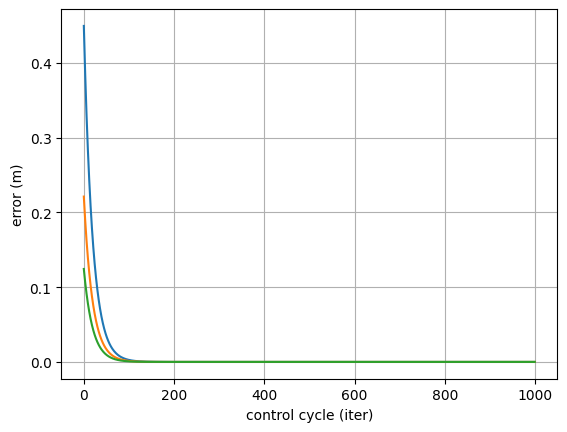

In [12]:
plt.plot(herr)
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)')
plt.grid()
plt.show;

We can observe that each component of the error converges toward 0 following an exponential trajetory. The convergence is assymptotic. To fasten the convergence, increase the gain of the control law ($v_q = - \lambda J^+ e$), where the gain $\lambda$ has yet been set to 1.


![](figures/inverse_kinematics_task_Translation_steps.png)


### Place the end effector (6D)
The previous control law brings the center of the effector toward the center of the goal frame. However, it does not control the orientation of the end effector: the axes of the two frames $F_{tool}$ and $F_{goal}$ do not converge.

We now want to modify the control law to take into account both tool translation and tool orientation. For that, let us compute the error in $SE(3)$. 

We will use the full ${}^{0} J_{tool}$ rather than ${}^o J_{tool3}$, and compute the error vector as the generalized difference between the tool frame and the goal frame:

$$^{tool}M_{goal} = \vphantom{.}^{0}M_{tool}^{-1} \vphantom{.}^{0}M_{goal}$$
$$^{tool}w_{goal} = \vphantom{.}^{0}M_{tool} \ominus_{SE(3)} \vphantom{.}^{0}M_{tool} = \log(^{tool}M_{goal})$$
where $^{tool}w_{goal}$ is a twist in the local frame.

In [13]:
pin.framesForwardKinematics(robot.model, robot.data, q)  # update Forward kinematic
o_Mtool = robot.data.oMf[IDX_TOOL].copy()
toolMgoal = o_Mtool.inverse() * o_Mgoal
tool_w = pin.log(toolMgoal).vector

This error `tool_w` is can be interpreted as the twist that should be applied during one second to displace the tool frame $F_{tool}$ (located at ${}^0 M_{tool}$) to the goal frame $F_{goal}$ (located at ${}^0 M_{goal}$).

Implement a second control law, following the same pattern as with positions. At each control cycle, you should:

* compute the displacement between $F_{tool}$ and $F_{goal}$, denoted by ``toolMgoal``
* compute the error twist ``tool_w`` using the logarithm over $SE(3)$
* compute the 6D Jacobian `tool_Jtool`
* compute the control law `vq = pinv(J) @ nu`
* integrate the robot velocity `vq` during `DT` to get to a new configuration `q`
* log the error by storing it in a list `herr`.

In [19]:
viz.display(q0)
for i in range(1000): 
    viz.delete(f"debug/traj{i}")
viz.delete("current_6D")
viz.delete("current")

In [20]:
q = q0.copy()
viz.display(q0)
DT = 4e-2
herr = [] # Log the value of the error between tool and goal.
IDX_SELEC = IDX_TOOL
for i in range(300):  # Integrate over 2 second of robot life
    pin.framesForwardKinematics(robot.model, robot.data, q)  # update Forward kinematic
    o_Mtool = robot.data.oMf[IDX_SELEC].copy()

    
    tool_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_SELEC, pin.LOCAL)
    
    toolMgoal = o_Mtool.inverse() * o_Mgoal
    tool_w = pin.log(toolMgoal).vector # error twist in the tool frame...


    vq = np.linalg.pinv(tool_Jtool) @ tool_w
    q = pin.integrate(robot.model, q, vq*DT)

    viz.display(q)
    time.sleep(1e-3)
    if i%20 and np.linalg.norm(tool_w)>0.05:
        viz.delete(f"debug/traj{i}")
        viz.addBox(f"debug/traj{i}", [0.08,.05,.05], [ 1. ,0., 1., 0.2] )
        viz.applyConfiguration(f"debug/traj{i}",o_Mtool)
    herr.append(tool_w) 

viz.delete("current_6D")
viz.addBox('current_6D', [.11,.11,.11], [ 1. ,1.,0., 0.6] )
viz.applyConfiguration('current_6D',o_Mtool)


The tool frame F_tool converges toward the gooal frame F_goal: the center and the axes are finally aligned. 
The trajectory of the tool center is not a straight line, as the frame F_tool follows a "straight" line, not in R^3 but in SE(3).
We can also plot the error (assuming that herr is a list of the 6D errors herr).

![](figures/inverse_kinematics_task_6D_steps_init.png)
![](figures/inverse_kinematics_task_6D_steps.png)



In [ ]:
plt.figure(figsize=(6, 12))
plt.subplot(211)
plt.plot([ e[:3] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('Translation error (m)')
plt.grid()
plt.subplot(212)
plt.plot([ e[3:] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('Angular error (rad)');
plt.grid()
plt.show()

### Inverse kinematics for two tasks
We yet controlled the robot with a single task (either the 3d position or the 6d placement errors). Let's see how to take into account a second task. Let's first introduce a second task. 

#### Introducing a second task: control the gaze
The robot has an additional frame named F_gaze, attached to the head and located 40 cm in front of the cameras. The task will be to position (3d) the center of this frame on an object of interest (a red ball).

In [22]:
robot = loadTiago(addGazeFrame=True)
viz = MeshcatVisualizer(robot)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [23]:
IDX_GAZE = robot.model.getFrameId('framegaze')
IDX_TOOL = robot.model.getFrameId('frametool')
IDX_BASIS = robot.model.getFrameId('framebasis')

# Add a small ball as a visual target to be reached by the robot
ball = np.array([ 1.2,0.5,1.1 ])
o_Mgazegoal = pin.SE3(np.eye(3), ball)
viz.addSphere('ball', .05, [ .8,.1,.5, .8] )
viz.applyConfiguration('ball', list(ball)+[0,0,0,1])

# Add the box again
o_Mgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(),
                np.array([1.2, .4, .7]))
viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6] )
viz.applyConfiguration('goal',o_Mgoal)

# Robot initial configuration.
q0 = np.array([ 0.  ,  0.  ,  1.  ,  0.  ,  0.18,  1.37, -0.24, -0.98,  0.98,
                0.  ,  0.  ,  0.  ,  0.  , -0.13,  0.  ,  0.  ,  0.  ,  0.  ])
viz.display(q0)
pin.framesForwardKinematics(robot.model,robot.data,q0)
# Then get the position
o_Mtool_start = robot.data.oMf[IDX_TOOL]
viz.delete("start")
viz.addBox('start', [.1,.1,.1], [ 1.,.1,.5, .6] )
viz.applyConfiguration('start',o_Mtool_start)


viz.display(q0)

In [24]:
viz.display(q0)
for i in range(10000): 
    viz.delete(f"debug/traj{i}")
    viz.delete(f"debug/traj_gaze{i}")
viz.delete("current_6D")
viz.delete("gaze")

Controlling this point can be done by achieving a simple variation of the control law for positioning (3d) the robot tool.

In [29]:
# CONTROLLING THE GAZE ONLY
viz.display(q0)
for i in range(500): 
    viz.delete(f"debug/traj{i}")
    viz.delete(f"debug/traj_gaze{i}")
viz.delete("current_6D")
q = q0.copy()

DT = 1e-2
herr = [] # Log the value of the error between tool and goal.
IDX_SELEC = IDX_TOOL
for i in range(300):  # Integrate over 2 second of robot life
    pin.framesForwardKinematics(robot.model, robot.data, q)  # update Forward kinematic
    
    o_MGaze = robot.data.oMf[IDX_GAZE].copy()
    o_JGaze3 = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_GAZE, pin.LOCAL_WORLD_ALIGNED)[:3, :]
    o_GazeGoal = o_Mgazegoal.translation - o_MGaze.translation
    vq_gaze = np.linalg.pinv(o_JGaze3) @ o_GazeGoal[:3]
    q = pin.integrate(robot.model, q, vq_gaze*DT)
    viz.display(q)
    time.sleep(0.5e-4)
    # if (i<100 and i%3==0) or (i>=100 and i%5 == 0) and np.linalg.norm(tool_w)>0.005:
    if i%3 ==0:
        viz.delete(f"debug/traj_gaze{i}")
        viz.addBox(f"debug/traj_gaze{i}", [0.02,.02,.02], [ 1. ,0., 0.5, 0.4] )
        viz.applyConfiguration(f"debug/traj_gaze{i}",o_MGaze)
    herr.append(tool_w) 

viz.delete("gaze")
viz.addBox('gaze', [.11,.11,.11], [ 1. ,1.,0., 0.6] )
viz.applyConfiguration('gaze',o_MGaze)


![](figures/inverse_kinematics_gaze_task.png)

Hey you!

## Some "empirical" exploratory attempt without maths, just trying to merging the 2 tasks by averaging the gradients.

![](figures/inverse_kinematics_2task_handcrafted.png)

In [30]:
# SKIP ME!
if True:
    viz.display(q0)
    for i in range(10000): 
        viz.delete(f"debug/traj{i}")
        viz.delete(f"debug/traj_gaze{i}")
    viz.delete("current_6D")
    q = q0.copy()

    DT = 5e-2
    herr = [] # Log the value of the error between tool and goal.
    IDX_SELEC = IDX_TOOL
    for i in range(4000):  # Integrate over 2 second of robot life
        pin.framesForwardKinematics(robot.model, robot.data, q)  # update Forward kinematic
        o_Mtool = robot.data.oMf[IDX_SELEC].copy()    
        tool_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_SELEC, pin.LOCAL)
        toolMgoal = o_Mtool.inverse() * o_Mgoal
        tool_w = pin.log(toolMgoal).vector
        vq_tool = np.linalg.pinv(tool_Jtool) @ tool_w

        o_MGaze = robot.data.oMf[IDX_GAZE].copy()
        o_JGaze3 = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_GAZE, pin.LOCAL_WORLD_ALIGNED)[:3, :]
        o_GazeGoal = o_Mgazegoal.translation - o_MGaze.translation
        vq_gaze = np.linalg.pinv(o_JGaze3) @ o_GazeGoal[:3]
        # q = pin.integrate(robot.model, q, vq_gaze*DT)
        q = pin.integrate(robot.model, q, (0.5*vq_gaze+0.5*vq_tool)*DT)
        viz.display(q)
        time.sleep(0.5e-4)
        if (i<100 and i%5==0) or (i>=100 and i%50 == 0) and np.linalg.norm(tool_w)>0.05:
            viz.delete(f"debug/traj{i}")
            viz.addBox(f"debug/traj{i}",  [0.08,.05,.05], [ 1. ,0., 1., 0.2]  )
            viz.applyConfiguration(f"debug/traj{i}",o_Mtool)
            viz.delete(f"debug/traj_gaze{i}")
            viz.addBox(f"debug/traj_gaze{i}", [0.02,.02,.02], [ 1. ,0., 0.5, 0.4] )
            viz.applyConfiguration(f"debug/traj_gaze{i}",o_MGaze)
        herr.append(tool_w) 

    viz.delete("current_6D")
    viz.addBox('current_6D', [.11,.11,.11], [ 1. ,1.,0., 0.6] )
    viz.applyConfiguration('current_6D',o_Mtool)


#### Multi-tasking

![ ](figures/inverse_kinematics_2task_by_projection.png)

We now have two tasks: 
- $(e_1, J_1)$ for controlling the tool placement
- $(e_2, J_2)$ for controlling the gaze position. 

We can use the previous derivation to compute the optimal (in a least square sense) control for task 1:

$$
vq_1 = J_1^+ v_1^*
$$

We may now add to $vq_1$ any vector that lies is in the nullspace of $J_1$ to perform the second task. We thus search for $vq = vq_1 + dvq$, 
> where $dvq$ gives an optimal control for task 2.

The orthogonal nullspace projector of $J_1$ can be computed using the pseudoinverse:

$$
P_1 = I_{nq} - J_1^+ J_1
$$

Finally, the control law to perform task 2 in the nullspace of task 1 is:

$$
vq_2 = vq_1 + (J_2 P_1)^+ ( v_2^* - J_2 vq_1)
$$

You can now implement a control law solving the two tasks, that is, positioning the tool while controlling the gaze. Use $dvq$ as a solution to the minimisation problem:

$$
\min_{x\in Ker(J_1)} \|J_2 (vq_1 + x) - v_2^*\|_2^2
$$


In [32]:
def reset(viz):
    viz.display(q0)
    for i in range(3000): 
        viz.delete(f"debug/traj{i}")
        viz.delete(f"debug/traj_gaze{i}")
    viz.delete("current_6D")
    viz.delete("gaze")
reset(viz)

In [33]:
reset(viz)
q = q0.copy()

DT = 5e-2
herr = [] # Log the value of the error between tool and goal.
herr2 = [] # Log the value of the error between gaze and ball.
for i in range(200):  # Integrate over 2 second of robot life
    pin.framesForwardKinematics(robot.model, robot.data, q)  # update Forward kinematic
    o_Mtool = robot.data.oMf[IDX_TOOL].copy()    
    tool_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_TOOL, pin.LOCAL)
    toolMgoal = o_Mtool.inverse() * o_Mgoal
    tool_w = pin.log(toolMgoal).vector
    tool_Jtool_inv = np.linalg.pinv(tool_Jtool)
    vq_tool = tool_Jtool_inv @ tool_w
    # vq1
    p1 = np.eye(robot.nv) - tool_Jtool_inv@ tool_Jtool  # Projector 



    o_MGaze = robot.data.oMf[IDX_GAZE].copy()
    o_JGaze = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_GAZE, pin.LOCAL_WORLD_ALIGNED)
    o_JGaze3 = o_JGaze[:3, :]
    o_GazeGoal = o_Mgazegoal.translation - o_MGaze.translation
    error_2 = np.concatenate([
        o_GazeGoal -  (o_JGaze@vq_tool)[:3],
        np.zeros(3)
    ])
    vq_gaze = vq_tool + np.linalg.pinv(o_JGaze @ p1) @ error_2
    

    q = pin.integrate(robot.model, q, vq_gaze*DT)
    herr.append(tool_w)
    herr2.append(o_GazeGoal)

    viz.display(q)
    time.sleep(1e-3)
    if (i<100 and i%2==0) or (i>=100 and i%10 == 0) and np.linalg.norm(tool_w)>0.05:
        viz.delete(f"debug/traj{i}")
        viz.addBox(f"debug/traj{i}",  [0.08,.05,.05], [ 1. ,0., 1., 0.2]  )
        viz.applyConfiguration(f"debug/traj{i}",o_Mtool)
        viz.delete(f"debug/traj_gaze{i}")
        viz.addBox(f"debug/traj_gaze{i}", [0.02,.02,.02], [ 1. ,0., 0.5, 0.4] )
        viz.applyConfiguration(f"debug/traj_gaze{i}",o_MGaze)



viz.delete("current_6D")
viz.addBox('current_6D', [.11,.11,.11], [ 1. ,1.,0., 0.6] )
viz.applyConfiguration('current_6D',o_Mtool)

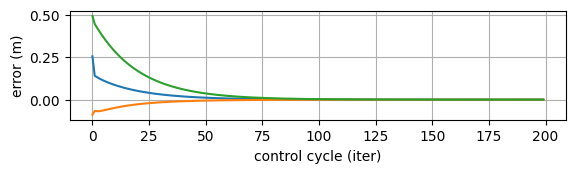

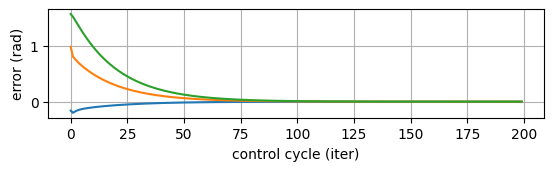

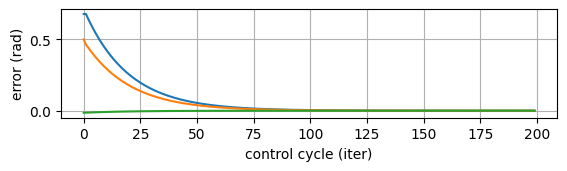

In [35]:
plt.subplot(311)
plt.plot([ e[:3] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)')
plt.grid()
plt.show();
plt.subplot(312)
plt.plot([ e[3:] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)')
plt.grid()
plt.show();
plt.subplot(313)
plt.plot([ e for e in herr2])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)')
plt.grid()
plt.show();


## Extension

A third task can be implemented as well by computing the null space of the two first tasks:

In [ ]:
# Pgaze = Ptool - pinv(o_Jgaze3 @ Ptool) @ o_Jgaze3 @ Ptool

$ P_0 = I_{nq} $

$ P_1 = I_{nq} - J_1^+ J_1 $


$ P_2 = P_1 - {(J_2 P_1)}^+ {J_2 P_1} $


$ P_3 = P_2 - {(J_3 P_2)}^+ {J_3 P_2} $


$ P_{n+1} = P_n - {(J_{n+1} P_n)}^+ {J_{n+1} P_n} $

Load an extra cube in the viewer to figure a table. First, control the robot hand to reach an arbitrary point on the table (don't worry about collisions). Then, implement a control law to control three tasks:
* The tool frame should be kept on the table = **vertical** constraint  (only the vertical component of the error matters, select the third row of the Jacobian and error accordingly).
* The gaze should reach the position of a ball positionned on the table.
* The center of the mobile base frame should reach a given goal on the floor. For this task, only the horizontal components (x- and y-) of the task matter, select only the first two rows of the Jacobian and error accordingly.

In [ ]:
robot = loadTiago(addGazeFrame=True)
viz = MeshcatVisualizer(robot)

In [ ]:
TABLE_HEIGHT = 0.9

IDX_GAZE = robot.model.getFrameId('framegaze')
IDX_TOOL = robot.model.getFrameId('frametool')
IDX_BASIS = robot.model.getFrameId('framebasis')

# Add a small ball as a visual target to be reached by the robot
# ball = np.array([ 1.2,0.5,1.1 ])
ball = np.array([ 1.2,0.5,TABLE_HEIGHT])
o_Mgazegoal = pin.SE3(np.eye(3), ball)
viz.addSphere('ball', .05, [ .8,.1,.5, .8] )
viz.applyConfiguration('ball', list(ball)+[0,0,0,1])

# Add the target on the floor
# basis_target_coordinates = ball + np.array([ 0.5 , 0.2, -ball[-1]])
basis_target_coordinates = ball + np.array([-0.2 , -0.2, -ball[-1]])
o_M_floorTarget = pin.SE3(np.eye(3), basis_target_coordinates)
viz.delete('basis_target')
viz.addBox('basis_target', [.1,.1,.4], [ 1.,0.,0., 1.] )
viz.applyConfiguration('basis_target',o_M_floorTarget)


# Add the table
table_coordinates = np.array([ 1., 1., TABLE_HEIGHT])
# table_coordinates = np.array([ -1.5, 1., TABLE_HEIGHT])
o_Mtable = pin.SE3(np.eye(3), table_coordinates)
viz.delete('table')
viz.addBox('table', [2. , 2.,.01], [ 1., 1., 1., .5] )
viz.applyConfiguration('table',o_Mtable)

# Robot initial configuration.
q0 = np.array([ 0.  ,  0.  ,  1.  ,  0.  ,  0.18,  1.37, -0.24, -0.98,  0.98,
                0.  ,  0.  ,  0.  ,  0.  , -0.13,  0.  ,  0.  ,  0.  ,  0.  ])
viz.display(q0)
pin.framesForwardKinematics(robot.model,robot.data,q0)
# Then get the position
o_Mtool_start = robot.data.oMf[IDX_TOOL]
viz.delete("start")
viz.addBox('start', [.1,.1,.1], [ 1.,.1,.5, .6] )
viz.applyConfiguration('start',o_Mtool_start)

In [ ]:
import pinocchio as pin
import numpy as np
from typing import List, Tuple

def extract_dim(vec: np.ndarray, start:int, end:int) -> np.ndarray:
    return vec[start:end, ...]


def get_config_velocity_update_translation_with_proj(
    q: np.ndarray,
    rob: pin.RobotWrapper,
    index_object: int,
    o_M_target: pin.SE3,
    constraints: Tuple[int, int] =(0, 3),
    projector: np.ndarray=None,
    vq_prev: np.ndarray=None
) -> Tuple[np.ndarray, np.ndarray]:
    """Get a configuration update (velocity vq) to move the object to the target position.
    When projector and vq_prev are None, this function behaves like the first iteration
    Which means that Identity projects into the whole space without constraint.
    Warning: Calling this function assumes that Foward Kinematics data is up to date.

    Args:
        q (np.ndarray): current configuration state.
            - (joint angles, basis position, etc...)
            - 15 scalars in case of the Tiago robot
        rob (pin.RobotWrapper): Robot instance.
        index_object (int): index of an object in the robot model (like effector or basis).
        o_M_target (pin.SE3): Target object position. SE(3) used here simply for its translation.
        constraints (Tuple[int, int], optional): Constrain only certain dimension of the target vector (from a to b).
            - Defaults to (0, 3) meaning no constraint.
            - (0,1) means constraining on the x axis.
            - (1,2) means constraining on the y axis.
            - (2,3) means constraining on the z axis.
            - (0,2) means constraining on the x & y axis.
        projector (np.ndarray, optional): Previous task projector matrix. Defaults to None.
            - Required not to deviate from the previous task direction - only evolve in the orthogonal space.
        vq_prev (np.ndarray, optional): Previous task velocity update. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray]: vq, projector
    """
    if projector is None:
        projector = np.eye(rob.nv) # Identity matrix
    if vq_prev is None:
        vq_prev =   np.zeros(rob.nv) # Null vector
    
    # Current object location -> o_Mcurrent 
    o_Mcurrent = rob.data.oMf[index_object]
    
    # Compute the error between the current object and the target object -> obj_2_goal
    obj_2_goal = (o_M_target.translation - o_Mcurrent.translation)
    obj_2_goalC = extract_dim(obj_2_goal, *constraints) # constraint on some specific dimensions

    # Compute the jacobian of the object -> o_J_obj , constrained on specific dimensions.
    o_J_obj = pin.computeFrameJacobian(rob.model, rob.data, q, index_object, pin.LOCAL_WORLD_ALIGNED)
    o_J_objC = extract_dim(o_J_obj, *constraints) # + constraint on some specific dimensions

    
    new_error = (obj_2_goalC - o_J_objC @ vq_prev)
    
    J = o_J_objC @ projector
    Jinv = np.linalg.pinv(J) # pinv(J2@P1)
    
    vq = vq_prev + Jinv @ new_error
    # Compute updated projector. 

    new_proj = projector - Jinv @ J
    # Note the special case when projector is the identity matrix,
    # we get the same result as the first iteration.

    return vq, new_proj



def solve_tasks(
    task_list: List[Tuple[int, pin.SE3, Tuple[int, int]]],
    DT:float=3e-2,
    Niter:int=700,
    viz=None,
    q_init=q0,
    rob=robot
):
    q = q_init.copy()
    viz.display(q_init)

    for it in range(Niter):  # Integrate over 2 second of rob life
        pin.framesForwardKinematics(rob.model, rob.data, q)  # update Forward kinematic
        vq, p = None, None

        for frame_id, o_M_target, constraints in task_list:
            # Iterate over the tasks
            vq, p = get_config_velocity_update_translation_with_proj(
                q, rob, frame_id, o_M_target, constraints=constraints,
                vq_prev=vq, projector=p
            )
        q = pin.integrate(rob.model, q, vq*DT)
        viz.display(q)
        time.sleep(1.E-3)

In [ ]:
# TOOL ON THE TABLE Z=[2:3]
TASK_1 = (IDX_TOOL, o_Mtable, (2,3))
# BASIS TOWARD THE CHECKPOINT ON THE FLOOR XY =[0:2]
TASK_2 = (IDX_BASIS, o_M_floorTarget, (0,2))
# GAZE TOWARD THE BALL XYZ =[0:3]
TASK_3 = (IDX_GAZE, o_Mgazegoal, (0,3))

# COMBINED TASKS
FULL_TASKS = [TASK_1, TASK_2, TASK_3]


Start far away from the goal

![](figures/triple_task_init.png)


Hands on the table, stare at the ball and basis on the red box on the floor!

![](figures/triple_task_end.png)


In [ ]:
solve_tasks(FULL_TASKS, DT=1e-2, Niter=400, viz=viz, q_init=q0, rob=robot)

#### Separate tasks 1, 1+2, 2+3

In [ ]:
solve_tasks([TASK_1], DT=3e-2, Niter=100, viz=viz, q_init=q0, rob=robot)
solve_tasks([TASK_2], DT=3e-2, Niter=100, viz=viz, q_init=q0, rob=robot)
solve_tasks([TASK_3], DT=3e-2, Niter=100, viz=viz, q_init=q0, rob=robot)

In [ ]:
solve_tasks([TASK_1, TASK_2], DT=3e-2, Niter=100, viz=viz, q_init=q0, rob=robot)

In [ ]:
solve_tasks([TASK_2, TASK_3], DT=3e-2, Niter=100, viz=viz, q_init=q0, rob=robot)